# CTRvision: Анализ эффективности продуктовых изображений

## Эксперименты

В этом блокноте проведено три типа экспериментов:

1. **Эксперимент 1**: Модель только на основе изображений (DINOv2)
2. **Эксперимент 2**: Модель только на основе табличных данных
3. **Эксперимент 3**: Комбинированная мультимодальная модель

---

## Настройки и инициализация

In [1]:
import warnings
import os
import sys
import yaml
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from IPython.display import display, HTML, Markdown

warnings.filterwarnings("ignore")
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
%load_ext autoreload
%autoreload 2

RED = "\033[31m"
GREEN = "\033[32m"
YELLOW = "\033[33m"
BLUE = "\033[34m"
MAGENTA = "\033[35m"
CYAN = "\033[36m"
RESET = "\033[0m"

def print_header(text, color=BLUE):
    print(f"\n{color}{'='*60}{RESET}")
    print(f"{color}{text:^60}{RESET}")
    print(f"{color}{'='*60}{RESET}\n")

def print_step(step_num, description, color=GREEN):
    print(f"{color} Шаг {step_num}: {description}{RESET}")

print_header("CTRvision Notebook Initialized", GREEN)


               CTRvision Notebook Initialized               



## Импорт модулей и настройка путей

Импортируем все необходимые модули для проведения экспериментов.

In [2]:
from scripts.download import DatasetDownloader
from scripts.train import train_model, create_data_loaders, initialize_model
from scripts.plot import plot_results
from scripts.dataset import CustomDataset, collate_fn
from model.classification_head import ImageClassifier, TabularClassifier, CombinedClassifier
from model.focal_loss import FocalLoss
from utils.config_parser import ConfigParser
from utils.custom_logging import get_logger
from __init__ import path_to_config, path_to_project

logger = get_logger(__name__)

print_step(1, "Все модули успешно импортированы", GREEN)

 Шаг 1: Все модули успешно импортированы


## Загрузка и анализ конфигурации

Загружаем базовую конфигурацию проекта и анализируем её параметры.

In [3]:
config_path = path_to_config()
base_config = ConfigParser().parse(config_path)

print_step(2, "Анализ базовой конфигурации", BLUE)

print(f"{CYAN} Конфигурация проекта:{RESET}")
print(f"  Датасет: {base_config['dataset_download']['dataset_name']}")
print(f"  Тип эксперимента: {base_config['train']['experiment_type']}")
print(f"  Количество эпох: {base_config['train']['num_epochs']}")
print(f"  Модель изображений: {base_config['model']['image_model_name']}")
print(f"  Learning rate: {base_config['train']['learning_rate']}")
print(f"  Focal Loss gamma: {base_config['train']['focal_loss_gamma']}")


def create_config_for_experiment(experiment_type, **kwargs):
    config = base_config.copy()
    config['train'] = config['train'].copy()
    config['model'] = config['model'].copy()
    
    config['train']['experiment_type'] = experiment_type
    
    for key, value in kwargs.items():
        if '.' in key:
            section, param = key.split('.', 1)
            if section not in config:
                config[section] = {}
            config[section][param] = value
        else:
            config['train'][key] = value
    
    return config

def save_temp_config(config, filename="temp_config.yaml"):
    temp_path = f"/tmp/{filename}"
    with open(temp_path, 'w') as f:
        yaml.dump(config, f, default_flow_style=False)
    return temp_path

print(f"\n{GREEN}Конфигурация загружена и функции помощники созданы{RESET}")

 Шаг 2: Анализ базовой конфигурации
 Конфигурация проекта:
  Датасет: paramaggarwal/fashion-product-images-small
  Тип эксперимента: image
  Количество эпох: 10
  Модель изображений: facebook/dinov2-base
  Learning rate: 0.001
  Focal Loss gamma: 2.0

Конфигурация загружена и функции помощники созданы


## Загрузка и подготовка датасета

Загружаем датасет модных товаров и подготавливаем его для обучения.

In [4]:
print_step(3, "Загрузка датасета", BLUE)
downloader = DatasetDownloader(base_config)
dataset_path = downloader.download()
print(f"\n{GREEN} Датасет готов: {dataset_path}{RESET}")

 Шаг 3: Загрузка датасета


20:09:57-108311 INFO     Starting download of dataset: paramaggarwal/fashion-product-images-small

20:09:58-271911 INFO     Dataset downloaded to cache:                                                              
                         /home/student/.cache/kagglehub/datasets/paramaggarwal/fashion-product-images-small/version
                         s/1

20:09:58-282538 DEBUG    Cache contents: ['myntradataset', 'images', 'styles.csv']

20:09:58-287095 INFO     Dataset already exists and overwrite is disabled. Skipping.


 Датасет готов: /home/student/projects/CTRvision/data/fashion-product-images-small


## Исследование и анализ данных

Проанализируем структуру датасета и подготовим данные для экспериментов.

In [5]:
print_step(4, "Анализ структуры данных", BLUE)

metadata_path = os.path.join(path_to_project(), base_config['data']['data_path'], base_config['data']['metadata_file'])
print(metadata_path)
df = pd.read_csv(metadata_path, engine='python', on_bad_lines='warn')

print(f"{CYAN} Информация о датасете:{RESET}")
print(f"  Размер датасета: {len(df)} образцов")
print(f"  Количество признаков: {len(df.columns)}")
print(f"  Колонки: {list(df.columns)}")

print(f"\n{YELLOW} Первые 5 строк данных:{RESET}")
display(df.head())

print(f"\n{YELLOW} Статистический анализ:{RESET}")
display(df.describe())

print(f"\n{YELLOW} Пропущенные значения:{RESET}")
missing_data = df.isnull().sum()
if missing_data.sum() > 0:
    display(missing_data[missing_data > 0])
else:
    print("Пропущенных значений не обнаружено")

from transformers import AutoImageProcessor
transform = AutoImageProcessor.from_pretrained(base_config['model']['image_model_name']).preprocess

sample_dataset = CustomDataset(
    data_path=os.path.join(path_to_project(), base_config['data']['data_path']),
    image_folder=base_config['data']['image_folder'],
    metadata_file=base_config['data']['metadata_file'],
    target_column=base_config['data'].get('target_column', None),
    target_percentile=base_config['data'].get('target_percentile', 0.8),
    transform=transform
)

print(f"\n{GREEN}Данные подготовлены для экспериментов{RESET}")
print(f"  Размер обработанного датасета: {len(sample_dataset)}")

sample = sample_dataset[0]
print(f"  Семпл: {sample['image'] if sample['image'] is not None else 'N/A'}")
print(f"  Размер табличных данных: {sample['tabular'].shape}")
print(f"  Целевая переменная: {sample['target']}")

 Шаг 4: Анализ структуры данных
/home/student/projects/CTRvision/data/fashion-product-images-small/styles.csv
 Информация о датасете:
  Размер датасета: 44424 образцов
  Количество признаков: 10
  Колонки: ['id', 'gender', 'masterCategory', 'subCategory', 'articleType', 'baseColour', 'season', 'year', 'usage', 'productDisplayName']

 Первые 5 строк данных:


,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt



 Статистический анализ:


,id,year
count,44424.000000,44423.000000
mean,29696.334301,2012.806497
std,17049.490518,2.126480
min,1163.000000,2007.000000
25%,14768.750000,2011.000000
50%,28618.500000,2012.000000
75%,44683.250000,2015.000000
max,60000.000000,2019.000000



 Пропущенные значения:


baseColour             15
season                 21
year                    1
usage                 317
productDisplayName      7
dtype: int64


Данные подготовлены для экспериментов
  Размер обработанного датасета: 44424
  Семпл: tensor([[[2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         ...,
         [2.2489, 2.2489, 2.2489,  ..., 2.1804, 2.1975, 2.2147],
         [2.2489, 2.2489, 2.2489,  ..., 2.1975, 2.1975, 2.2147],
         [2.2489, 2.2489, 2.2489,  ..., 2.1975, 2.2147, 2.2318]],

        [[2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
         [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
         [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
         ...,
         [2.3585, 2.3761, 2.3936,  ..., 2.3936, 2.4111, 2.4111],
         [2.3585, 2.3761, 2.3936,  ..., 2.4111, 2.4111, 2.4111],
         [2.3761, 2.3761, 2.3936,  ..., 2.4111, 2.4286, 2.4286]],

        [[2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
         [2.6400, 2.6400, 2.6400,  .

# Эксперимент 1: Модель только на основе изображений

## Описание эксперимента

В этом эксперименте мы используем только **изображения продуктов** для предсказания CTR. Модель основана на предобученной архитектуре **DINOv2**, которая обеспечивает мощные визуальные представления.

### Параметры эксперимента:
- **Тип модели**: Image-only (DINOv2)
- **Размер батча**: 32
- **Learning rate**: 0.001
- **Количество эпох**: 15
- **Focal Loss gamma**: 2.0

In [6]:
print_header("ЭКСПЕРИМЕНТ 1: ТОЛЬКО ИЗОБРАЖЕНИЯ", MAGENTA)

image_config = create_config_for_experiment(
    "image",
    batch_size=32,
    num_workers=4,
    learning_rate=0.0001,
    num_epochs=5,
    focal_loss_gamma=2.0
)

print_step("1.1", "Конфигурация создана", GREEN)
print(f"  Тип эксперимента: {image_config['train']['experiment_type']}")
print(f"  Размер батча: {image_config['train']['batch_size']}")
print(f"  Learning rate: {image_config['train']['learning_rate']}")
print(f"  Focal Loss gamma: {image_config['train']['focal_loss_gamma']}")


             ЭКСПЕРИМЕНТ 1: ТОЛЬКО ИЗОБРАЖЕНИЯ              

 Шаг 1.1: Конфигурация создана
  Тип эксперимента: image
  Размер батча: 32
  Learning rate: 0.0001
  Focal Loss gamma: 2.0


In [7]:
print_step("1.2", "Запуск обучения модели на изображениях", BLUE)
image_model, image_metrics = train_model(image_config)
print_step("1.3", "Визуализация результатов", CYAN)
plot_results(image_config)
print(f"\n{GREEN} Эксперимент 1 завершен!{RESET}")

 Шаг 1.2: Запуск обучения модели на изображениях


20:10:08-142341 INFO     Using device: cuda

Error loading image /home/student/projects/CTRvision/data/fashion-product-images-small/images/39425.jpg: [Errno 2] No such file or directory: '/home/student/projects/CTRvision/data/fashion-product-images-small/images/39425.jpg'
Error loading image /home/student/projects/CTRvision/data/fashion-product-images-small/images/39403.jpg: [Errno 2] No such file or directory: '/home/student/projects/CTRvision/data/fashion-product-images-small/images/39403.jpg'
Error loading image /home/student/projects/CTRvision/data/fashion-product-images-small/images/39410.jpg: [Errno 2] No such file or directory: '/home/student/projects/CTRvision/data/fashion-product-images-small/images/39410.jpg'
Error loading image /home/student/projects/CTRvision/data/fashion-product-images-small/images/12347.jpg: [Errno 2] No such file or directory: '/home/student/projects/CTRvision/data/fashion-product-images-small/images/12347.jpg'
Error loading image /home/student/projects/CTRvision/data/fashion-product-images-small/i

20:14:23-491321 INFO     Epoch 1/5, Train Loss: 0.1543, Val Loss: 0.1463, Val Accuracy: 75.55%

Error loading image /home/student/projects/CTRvision/data/fashion-product-images-small/images/39401.jpg: [Errno 2] No such file or directory: '/home/student/projects/CTRvision/data/fashion-product-images-small/images/39401.jpg'
Error loading image /home/student/projects/CTRvision/data/fashion-product-images-small/images/12347.jpg: [Errno 2] No such file or directory: '/home/student/projects/CTRvision/data/fashion-product-images-small/images/12347.jpg'
Error loading image /home/student/projects/CTRvision/data/fashion-product-images-small/images/39410.jpg: [Errno 2] No such file or directory: '/home/student/projects/CTRvision/data/fashion-product-images-small/images/39410.jpg'
Error loading image /home/student/projects/CTRvision/data/fashion-product-images-small/images/39425.jpg: [Errno 2] No such file or directory: '/home/student/projects/CTRvision/data/fashion-product-images-small/images/39425.jpg'
Error loading image /home/student/projects/CTRvision/data/fashion-product-images-small/i

20:18:23-814645 INFO     Epoch 2/5, Train Loss: 0.1420, Val Loss: 0.1448, Val Accuracy: 75.66%

Error loading image /home/student/projects/CTRvision/data/fashion-product-images-small/images/39401.jpg: [Errno 2] No such file or directory: '/home/student/projects/CTRvision/data/fashion-product-images-small/images/39401.jpg'
Error loading image /home/student/projects/CTRvision/data/fashion-product-images-small/images/39403.jpg: [Errno 2] No such file or directory: '/home/student/projects/CTRvision/data/fashion-product-images-small/images/39403.jpg'
Error loading image /home/student/projects/CTRvision/data/fashion-product-images-small/images/39410.jpg: [Errno 2] No such file or directory: '/home/student/projects/CTRvision/data/fashion-product-images-small/images/39410.jpg'
Error loading image /home/student/projects/CTRvision/data/fashion-product-images-small/images/39425.jpg: [Errno 2] No such file or directory: '/home/student/projects/CTRvision/data/fashion-product-images-small/images/39425.jpg'
Error loading image /home/student/projects/CTRvision/data/fashion-product-images-small/i

20:22:22-229837 INFO     Epoch 3/5, Train Loss: 0.1395, Val Loss: 0.1453, Val Accuracy: 75.55%

Error loading image /home/student/projects/CTRvision/data/fashion-product-images-small/images/39401.jpg: [Errno 2] No such file or directory: '/home/student/projects/CTRvision/data/fashion-product-images-small/images/39401.jpg'
Error loading image /home/student/projects/CTRvision/data/fashion-product-images-small/images/39425.jpg: [Errno 2] No such file or directory: '/home/student/projects/CTRvision/data/fashion-product-images-small/images/39425.jpg'
Error loading image /home/student/projects/CTRvision/data/fashion-product-images-small/images/39403.jpg: [Errno 2] No such file or directory: '/home/student/projects/CTRvision/data/fashion-product-images-small/images/39403.jpg'
Error loading image /home/student/projects/CTRvision/data/fashion-product-images-small/images/39410.jpg: [Errno 2] No such file or directory: '/home/student/projects/CTRvision/data/fashion-product-images-small/images/39410.jpg'
Error loading image /home/student/projects/CTRvision/data/fashion-product-images-small/i

20:26:23-843295 INFO     Epoch 4/5, Train Loss: 0.1377, Val Loss: 0.1470, Val Accuracy: 75.35%

Error loading image /home/student/projects/CTRvision/data/fashion-product-images-small/images/39425.jpg: [Errno 2] No such file or directory: '/home/student/projects/CTRvision/data/fashion-product-images-small/images/39425.jpg'
Error loading image /home/student/projects/CTRvision/data/fashion-product-images-small/images/12347.jpg: [Errno 2] No such file or directory: '/home/student/projects/CTRvision/data/fashion-product-images-small/images/12347.jpg'
Error loading image /home/student/projects/CTRvision/data/fashion-product-images-small/images/39403.jpg: [Errno 2] No such file or directory: '/home/student/projects/CTRvision/data/fashion-product-images-small/images/39403.jpg'
Error loading image /home/student/projects/CTRvision/data/fashion-product-images-small/images/39410.jpg: [Errno 2] No such file or directory: '/home/student/projects/CTRvision/data/fashion-product-images-small/images/39410.jpg'
Error loading image /home/student/projects/CTRvision/data/fashion-product-images-small/i

20:30:22-382789 INFO     Epoch 5/5, Train Loss: 0.1358, Val Loss: 0.1468, Val Accuracy: 75.37%

20:30:23-456445 INFO     Model saved to weights/image_model.pth

20:30:23-462436 INFO     Metrics saved to metrics/image_metrics.pt

 Шаг 1.3: Визуализация результатов


20:31:13-196832 INFO     Plots and metrics saved to plots

20:31:13-208687 INFO     Final Validation Accuracy: 75.37%

20:31:13-213186 INFO     ROC AUC: 0.5027


 Эксперимент 1 завершен!


# Эксперимент 2: Модель только на основе табличных данных

## Описание эксперимента

В этом эксперименте мы используем только **метаданные продуктов** (цена, категория, пол и другие атрибуты) для предсказания CTR. Это поможет понять, насколько информативны числовые и категориальные признаки.

### Параметры эксперимента:
- **Тип модели**: Tabular-only (MLP)
- **Размер батча**: 64
- **Learning rate**: 0.0001
- **Количество эпох**: 5
- **Focal Loss gamma**: 2.0
- **Архитектура**: [512, 256, 128]

In [8]:
print_header("ЭКСПЕРИМЕНТ 2: ТОЛЬКО ТАБЛИЧНЫЕ ДАННЫЕ", MAGENTA)

tabular_config = create_config_for_experiment(
    "tabular",
    batch_size=64,
    num_workers=4,
    learning_rate=0.0001,
    num_epochs=5,
    focal_loss_gamma=2.0,
    **{"model.tabular_hidden_sizes": [512, 256, 128]}
)

print_step("2.1", "Конфигурация создана", GREEN)
print(f"  Тип эксперимента: {tabular_config['train']['experiment_type']}")
print(f"  Размер батча: {tabular_config['train']['batch_size']}")
print(f"  Learning rate: {tabular_config['train']['learning_rate']}")
print(f"  Focal Loss gamma: {tabular_config['train']['focal_loss_gamma']}")
print(f"  Архитектура: {tabular_config['model']['tabular_hidden_sizes']}")


           ЭКСПЕРИМЕНТ 2: ТОЛЬКО ТАБЛИЧНЫЕ ДАННЫЕ           

 Шаг 2.1: Конфигурация создана
  Тип эксперимента: tabular
  Размер батча: 64
  Learning rate: 0.0001
  Focal Loss gamma: 2.0
  Архитектура: [512, 256, 128]


In [9]:
print_step("2.2", "Запуск обучения модели на табличных данных", BLUE)
tabular_model, tabular_metrics = train_model(tabular_config)
print_step("2.3", "Визуализация результатов", CYAN)
plot_results(tabular_config)
print(f"\n{GREEN} Эксперимент 2 завершен!{RESET}")

 Шаг 2.2: Запуск обучения модели на табличных данных


20:31:14-030771 INFO     Using device: cuda

Error loading image /home/student/projects/CTRvision/data/fashion-product-images-small/images/12347.jpg: [Errno 2] No such file or directory: '/home/student/projects/CTRvision/data/fashion-product-images-small/images/12347.jpg'
Error loading image /home/student/projects/CTRvision/data/fashion-product-images-small/images/39403.jpg: [Errno 2] No such file or directory: '/home/student/projects/CTRvision/data/fashion-product-images-small/images/39403.jpg'
Error loading image /home/student/projects/CTRvision/data/fashion-product-images-small/images/39410.jpg: [Errno 2] No such file or directory: '/home/student/projects/CTRvision/data/fashion-product-images-small/images/39410.jpg'
Error loading image /home/student/projects/CTRvision/data/fashion-product-images-small/images/39401.jpg: [Errno 2] No such file or directory: '/home/student/projects/CTRvision/data/fashion-product-images-small/images/39401.jpg'
Error loading image /home/student/projects/CTRvision/data/fashion-product-images-small/i

20:35:26-270171 INFO     Epoch 1/5, Train Loss: 0.4015, Val Loss: nan, Val Accuracy: 75.73%

Error loading image /home/student/projects/CTRvision/data/fashion-product-images-small/images/39425.jpg: [Errno 2] No such file or directory: '/home/student/projects/CTRvision/data/fashion-product-images-small/images/39425.jpg'
Error loading image /home/student/projects/CTRvision/data/fashion-product-images-small/images/39410.jpg: [Errno 2] No such file or directory: '/home/student/projects/CTRvision/data/fashion-product-images-small/images/39410.jpg'
Error loading image /home/student/projects/CTRvision/data/fashion-product-images-small/images/39403.jpg: [Errno 2] No such file or directory: '/home/student/projects/CTRvision/data/fashion-product-images-small/images/39403.jpg'
Error loading image /home/student/projects/CTRvision/data/fashion-product-images-small/images/39401.jpg: [Errno 2] No such file or directory: '/home/student/projects/CTRvision/data/fashion-product-images-small/images/39401.jpg'
Error loading image /home/student/projects/CTRvision/data/fashion-product-images-small/i

20:39:21-046630 INFO     Epoch 2/5, Train Loss: 0.1495, Val Loss: nan, Val Accuracy: 75.73%

Error loading image /home/student/projects/CTRvision/data/fashion-product-images-small/images/39401.jpg: [Errno 2] No such file or directory: '/home/student/projects/CTRvision/data/fashion-product-images-small/images/39401.jpg'
Error loading image /home/student/projects/CTRvision/data/fashion-product-images-small/images/12347.jpg: [Errno 2] No such file or directory: '/home/student/projects/CTRvision/data/fashion-product-images-small/images/12347.jpg'
Error loading image /home/student/projects/CTRvision/data/fashion-product-images-small/images/39403.jpg: [Errno 2] No such file or directory: '/home/student/projects/CTRvision/data/fashion-product-images-small/images/39403.jpg'
Error loading image /home/student/projects/CTRvision/data/fashion-product-images-small/images/39410.jpg: [Errno 2] No such file or directory: '/home/student/projects/CTRvision/data/fashion-product-images-small/images/39410.jpg'
Error loading image /home/student/projects/CTRvision/data/fashion-product-images-small/i

20:43:17-451774 INFO     Epoch 3/5, Train Loss: 0.1445, Val Loss: nan, Val Accuracy: 75.73%

Error loading image /home/student/projects/CTRvision/data/fashion-product-images-small/images/12347.jpg: [Errno 2] No such file or directory: '/home/student/projects/CTRvision/data/fashion-product-images-small/images/12347.jpg'
Error loading image /home/student/projects/CTRvision/data/fashion-product-images-small/images/39410.jpg: [Errno 2] No such file or directory: '/home/student/projects/CTRvision/data/fashion-product-images-small/images/39410.jpg'
Error loading image /home/student/projects/CTRvision/data/fashion-product-images-small/images/39401.jpg: [Errno 2] No such file or directory: '/home/student/projects/CTRvision/data/fashion-product-images-small/images/39401.jpg'
Error loading image /home/student/projects/CTRvision/data/fashion-product-images-small/images/39403.jpg: [Errno 2] No such file or directory: '/home/student/projects/CTRvision/data/fashion-product-images-small/images/39403.jpg'
Error loading image /home/student/projects/CTRvision/data/fashion-product-images-small/i

20:47:10-762466 INFO     Epoch 4/5, Train Loss: 0.1435, Val Loss: nan, Val Accuracy: 75.73%

Error loading image /home/student/projects/CTRvision/data/fashion-product-images-small/images/39401.jpg: [Errno 2] No such file or directory: '/home/student/projects/CTRvision/data/fashion-product-images-small/images/39401.jpg'
Error loading image /home/student/projects/CTRvision/data/fashion-product-images-small/images/39410.jpg: [Errno 2] No such file or directory: '/home/student/projects/CTRvision/data/fashion-product-images-small/images/39410.jpg'
Error loading image /home/student/projects/CTRvision/data/fashion-product-images-small/images/39403.jpg: [Errno 2] No such file or directory: '/home/student/projects/CTRvision/data/fashion-product-images-small/images/39403.jpg'
Error loading image /home/student/projects/CTRvision/data/fashion-product-images-small/images/39425.jpg: [Errno 2] No such file or directory: '/home/student/projects/CTRvision/data/fashion-product-images-small/images/39425.jpg'
Error loading image /home/student/projects/CTRvision/data/fashion-product-images-small/i

20:51:04-290734 INFO     Epoch 5/5, Train Loss: 0.1431, Val Loss: nan, Val Accuracy: 75.73%

20:51:04-301357 INFO     Model saved to weights/tabular_model.pth

20:51:04-311992 INFO     Metrics saved to metrics/tabular_metrics.pt

 Шаг 2.3: Визуализация результатов


20:51:49-310196 INFO     Plots and metrics saved to plots

20:51:49-357615 INFO     Final Validation Accuracy: 75.73%

20:51:49-566792 INFO     ROC AUC: 0.5186


 Эксперимент 2 завершен!


# Эксперимент 3: Комбинированная мультимодальная модель

## Описание эксперимента

В этом эксперименте мы объединяем **изображения и табличные данные** для создания мультимодальной модели. Это должно дать наилучшие результаты, так как модель использует всю доступную информацию о продуктах.

### Параметры эксперимента:
- **Тип модели**: Combined (DINOv2 + MLP)
- **Размер батча**: 24 (меньше из-за большего размера модели)
- **Learning rate**: 0.0001
- **Количество эпох**: 5
- **Focal Loss gamma**: 2.0
- **Архитектура**: Image features + Tabular [512, 256] → Combined [512, 256]

In [10]:
print_header("ЭКСПЕРИМЕНТ 3: КОМБИНИРОВАННАЯ МОДЕЛЬ", MAGENTA)

combined_config = create_config_for_experiment(
    "combined",
    batch_size=24,
    num_workers=4,
    learning_rate=0.0001,
    num_epochs=5,
    focal_loss_gamma=2.0,
    **{
        "model.tabular_hidden_sizes": [512, 256],
        "model.combined_hidden_sizes": [512, 256]
    }
)

print_step("3.1", "Конфигурация создана", GREEN)
print(f"  Тип эксперимента: {combined_config['train']['experiment_type']}")
print(f"  Размер батча: {combined_config['train']['batch_size']}")
print(f"  Learning rate: {combined_config['train']['learning_rate']}")
print(f"  Focal Loss gamma: {combined_config['train']['focal_loss_gamma']}")
print(f"  Табличная архитектура: {combined_config['model']['tabular_hidden_sizes']}")
print(f"  Комбинированная архитектура: {combined_config['model']['combined_hidden_sizes']}")


           ЭКСПЕРИМЕНТ 3: КОМБИНИРОВАННАЯ МОДЕЛЬ            

 Шаг 3.1: Конфигурация создана
  Тип эксперимента: combined
  Размер батча: 24
  Learning rate: 0.0001
  Focal Loss gamma: 2.0
  Табличная архитектура: [512, 256]
  Комбинированная архитектура: [512, 256]


In [11]:
print_step("3.2", "Запуск обучения комбинированной модели", BLUE)
combined_model, combined_metrics = train_model(combined_config)
print_step("3.3", "Визуализация результатов", CYAN)
plot_results(combined_config)
print(f"\n{GREEN}✅ Эксперимент 3 завершен!{RESET}")

 Шаг 3.2: Запуск обучения комбинированной модели


20:51:49-774713 INFO     Using device: cuda

Error loading image /home/student/projects/CTRvision/data/fashion-product-images-small/images/39425.jpg: [Errno 2] No such file or directory: '/home/student/projects/CTRvision/data/fashion-product-images-small/images/39425.jpg'
Error loading image /home/student/projects/CTRvision/data/fashion-product-images-small/images/12347.jpg: [Errno 2] No such file or directory: '/home/student/projects/CTRvision/data/fashion-product-images-small/images/12347.jpg'
Error loading image /home/student/projects/CTRvision/data/fashion-product-images-small/images/39401.jpg: [Errno 2] No such file or directory: '/home/student/projects/CTRvision/data/fashion-product-images-small/images/39401.jpg'
Error loading image /home/student/projects/CTRvision/data/fashion-product-images-small/images/39403.jpg: [Errno 2] No such file or directory: '/home/student/projects/CTRvision/data/fashion-product-images-small/images/39403.jpg'
Error loading image /home/student/projects/CTRvision/data/fashion-product-images-small/i

20:56:17-510227 INFO     Epoch 1/5, Train Loss: 0.1696, Val Loss: nan, Val Accuracy: 75.73%

Error loading image /home/student/projects/CTRvision/data/fashion-product-images-small/images/39425.jpg: [Errno 2] No such file or directory: '/home/student/projects/CTRvision/data/fashion-product-images-small/images/39425.jpg'
Error loading image /home/student/projects/CTRvision/data/fashion-product-images-small/images/39403.jpg: [Errno 2] No such file or directory: '/home/student/projects/CTRvision/data/fashion-product-images-small/images/39403.jpg'
Error loading image /home/student/projects/CTRvision/data/fashion-product-images-small/images/12347.jpg: [Errno 2] No such file or directory: '/home/student/projects/CTRvision/data/fashion-product-images-small/images/12347.jpg'
Error loading image /home/student/projects/CTRvision/data/fashion-product-images-small/images/39410.jpg: [Errno 2] No such file or directory: '/home/student/projects/CTRvision/data/fashion-product-images-small/images/39410.jpg'
Error loading image /home/student/projects/CTRvision/data/fashion-product-images-small/i

21:00:28-293291 INFO     Epoch 2/5, Train Loss: 0.1432, Val Loss: nan, Val Accuracy: 75.73%

Error loading image /home/student/projects/CTRvision/data/fashion-product-images-small/images/39401.jpg: [Errno 2] No such file or directory: '/home/student/projects/CTRvision/data/fashion-product-images-small/images/39401.jpg'
Error loading image /home/student/projects/CTRvision/data/fashion-product-images-small/images/39425.jpg: [Errno 2] No such file or directory: '/home/student/projects/CTRvision/data/fashion-product-images-small/images/39425.jpg'
Error loading image /home/student/projects/CTRvision/data/fashion-product-images-small/images/39410.jpg: [Errno 2] No such file or directory: '/home/student/projects/CTRvision/data/fashion-product-images-small/images/39410.jpg'
Error loading image /home/student/projects/CTRvision/data/fashion-product-images-small/images/39403.jpg: [Errno 2] No such file or directory: '/home/student/projects/CTRvision/data/fashion-product-images-small/images/39403.jpg'
Error loading image /home/student/projects/CTRvision/data/fashion-product-images-small/i

21:04:36-811063 INFO     Epoch 3/5, Train Loss: 0.1426, Val Loss: nan, Val Accuracy: 75.73%

Error loading image /home/student/projects/CTRvision/data/fashion-product-images-small/images/39401.jpg: [Errno 2] No such file or directory: '/home/student/projects/CTRvision/data/fashion-product-images-small/images/39401.jpg'
Error loading image /home/student/projects/CTRvision/data/fashion-product-images-small/images/39403.jpg: [Errno 2] No such file or directory: '/home/student/projects/CTRvision/data/fashion-product-images-small/images/39403.jpg'
Error loading image /home/student/projects/CTRvision/data/fashion-product-images-small/images/39410.jpg: [Errno 2] No such file or directory: '/home/student/projects/CTRvision/data/fashion-product-images-small/images/39410.jpg'
Error loading image /home/student/projects/CTRvision/data/fashion-product-images-small/images/39425.jpg: [Errno 2] No such file or directory: '/home/student/projects/CTRvision/data/fashion-product-images-small/images/39425.jpg'
Error loading image /home/student/projects/CTRvision/data/fashion-product-images-small/i

21:08:42-641710 INFO     Epoch 4/5, Train Loss: 0.1421, Val Loss: nan, Val Accuracy: 75.73%

Error loading image /home/student/projects/CTRvision/data/fashion-product-images-small/images/39401.jpg: [Errno 2] No such file or directory: '/home/student/projects/CTRvision/data/fashion-product-images-small/images/39401.jpg'
Error loading image /home/student/projects/CTRvision/data/fashion-product-images-small/images/39425.jpg: [Errno 2] No such file or directory: '/home/student/projects/CTRvision/data/fashion-product-images-small/images/39425.jpg'
Error loading image /home/student/projects/CTRvision/data/fashion-product-images-small/images/12347.jpg: [Errno 2] No such file or directory: '/home/student/projects/CTRvision/data/fashion-product-images-small/images/12347.jpg'
Error loading image /home/student/projects/CTRvision/data/fashion-product-images-small/images/39410.jpg: [Errno 2] No such file or directory: '/home/student/projects/CTRvision/data/fashion-product-images-small/images/39410.jpg'
Error loading image /home/student/projects/CTRvision/data/fashion-product-images-small/i

21:12:54-938869 INFO     Epoch 5/5, Train Loss: 0.1417, Val Loss: nan, Val Accuracy: 75.73%

21:12:55-874619 INFO     Model saved to weights/combined_model.pth

21:12:55-877309 INFO     Metrics saved to metrics/combined_metrics.pt

 Шаг 3.3: Визуализация результатов


21:13:45-142050 INFO     Plots and metrics saved to plots

21:13:45-145437 INFO     Final Validation Accuracy: 75.73%

21:13:45-150266 INFO     ROC AUC: 0.5167


✅ Эксперимент 3 завершен!


# Сравнение результатов всех экспериментов

## Итоговое сравнение моделей

Проанализируем производительность всех трех подходов и определим, какой из них наиболее эффективен для предсказания CTR продуктов.

In [12]:
print_header("ИТОГОВОЕ СРАВНЕНИЕ ЭКСПЕРИМЕНТОВ", CYAN)

experiment_types = ["image", "tabular", "combined"]
results = {}

for exp_type in experiment_types:
    metrics_path = os.path.join(base_config['paths']['metrics_path'], exp_type, f"{exp_type}_metrics.pt")
    if os.path.exists(metrics_path):
        metrics = torch.load(metrics_path)
        results[exp_type] = {
            'best_accuracy': max(metrics['val_accuracies']),
            'final_accuracy': metrics['val_accuracies'][-1],
            'final_loss': metrics['val_losses'][-1],
            'config': metrics['config']
        }

print(f"{YELLOW} Сводная таблица результатов:{RESET}")
print(f"{'Модель':<20} {'Лучшая точность (%)':<20} {'Финальная точность (%)':<25} {'Финальные потери':<15}")
print("-" * 85)

for model_name, metrics in results.items():
    print(f"{model_name:<20} {metrics['best_accuracy']:<20.2f} {metrics['final_accuracy']:<25.2f} {metrics['final_loss']:<15.4f}")

if results:
    best_model = max(results.items(), key=lambda x: x[1]['best_accuracy'])
    print(f"\n{GREEN} Лучшая модель: {best_model[0]} (лучшая точность: {best_model[1]['best_accuracy']:.2f}%){RESET}")


              ИТОГОВОЕ СРАВНЕНИЕ ЭКСПЕРИМЕНТОВ              

 Сводная таблица результатов:
Модель               Лучшая точность (%)  Финальная точность (%)    Финальные потери
-------------------------------------------------------------------------------------


 Шаг 4.1: Сравнительная визуализация


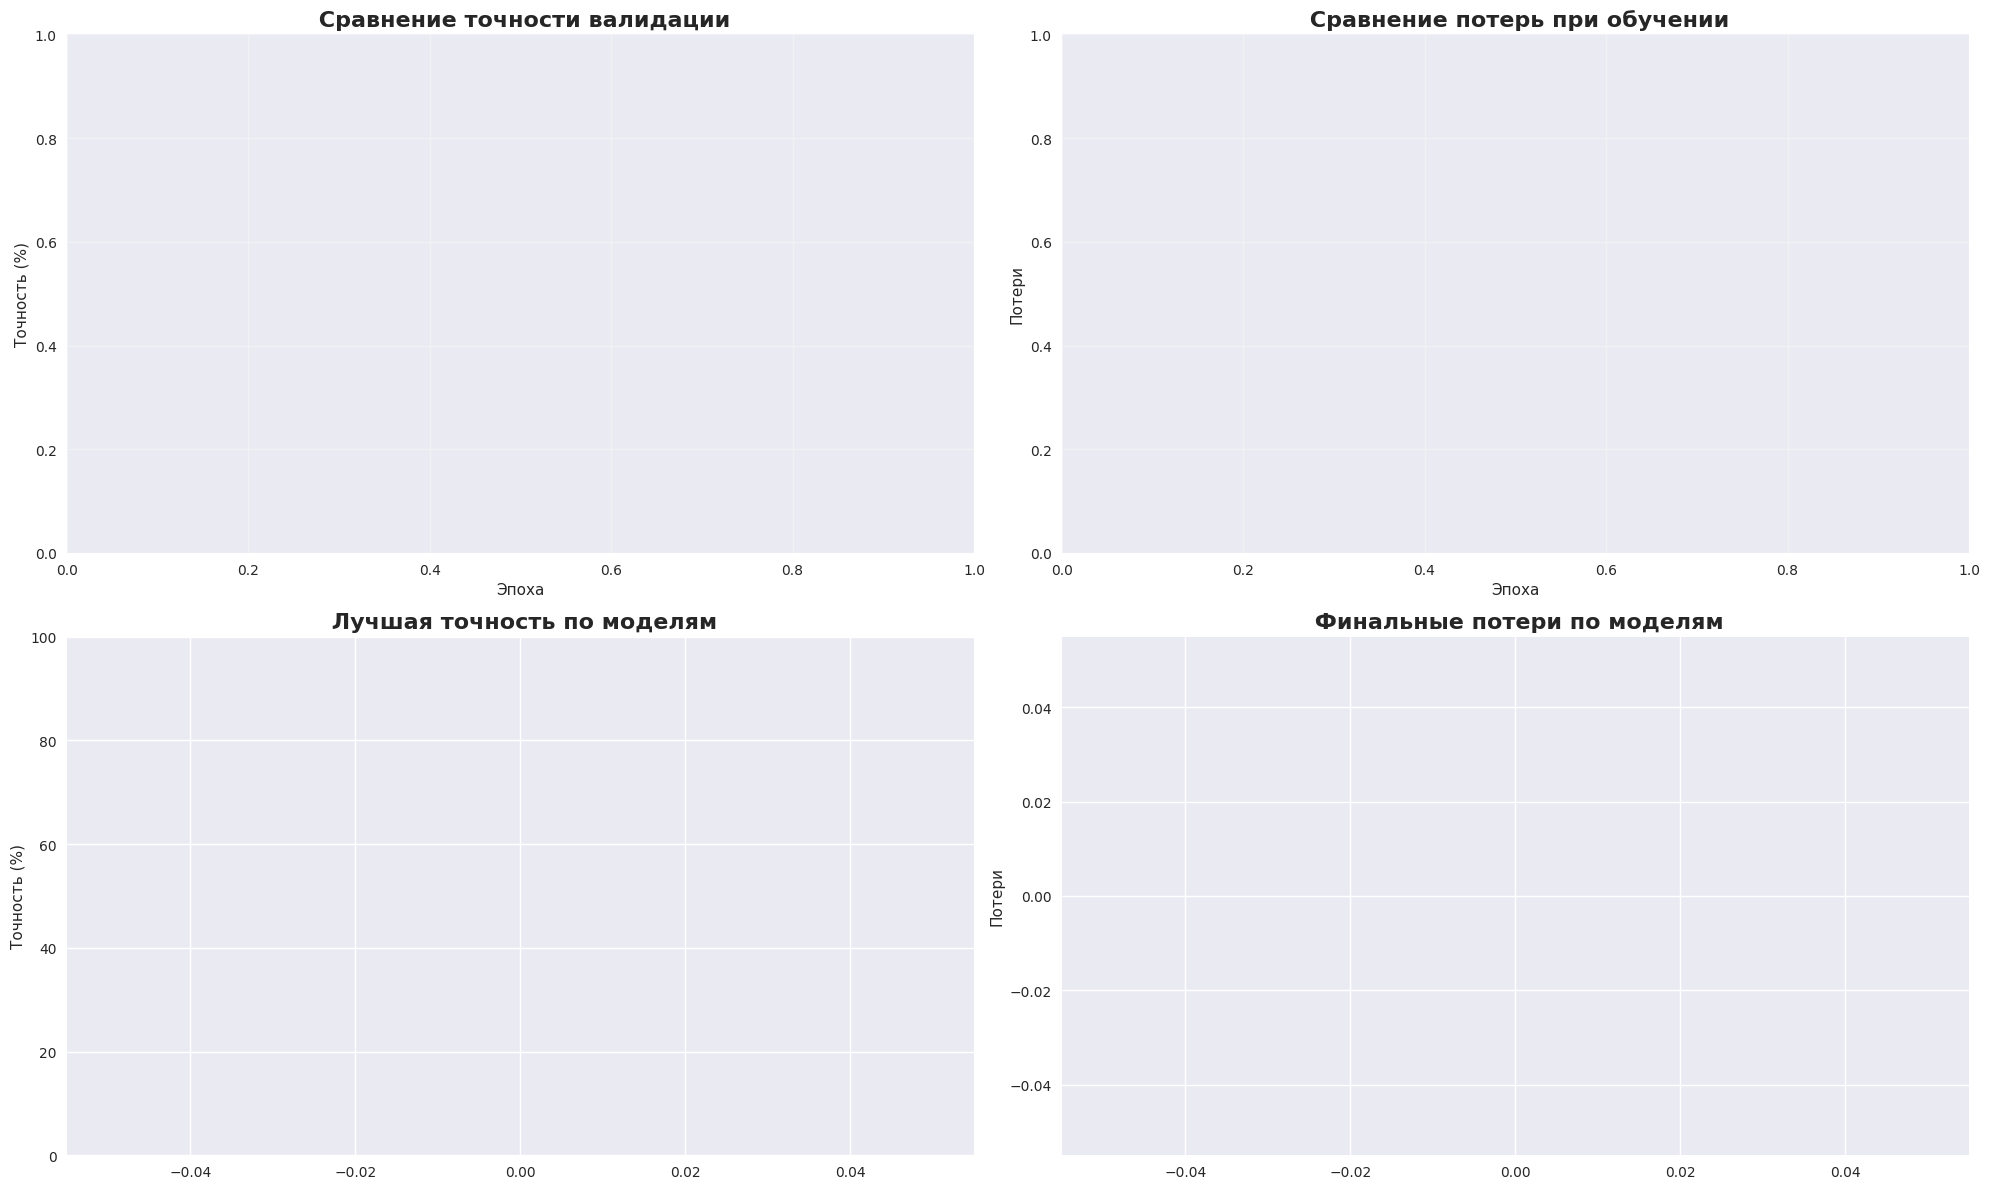


✅ Сравнение экспериментов завершено!


In [13]:
print_step("4.1", "Сравнительная визуализация", CYAN)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 12))

colors = {'image': 'blue', 'tabular': 'green', 'combined': 'purple'}
for exp_type in experiment_types:
    if exp_type in results:
        metrics_path = os.path.join(base_config['paths']['metrics_path'], exp_type, f"{exp_type}_metrics.pt")
        metrics = torch.load(metrics_path)
        epochs = range(1, len(metrics['val_accuracies']) + 1)
        ax1.plot(epochs, metrics['val_accuracies'], label=exp_type, color=colors[exp_type], linewidth=2, marker='o')

ax1.set_title(' Сравнение точности валидации', fontsize=16, fontweight='bold')
ax1.set_xlabel('Эпоха')
ax1.set_ylabel('Точность (%)')
ax1.legend()
ax1.grid(True, alpha=0.3)

for exp_type in experiment_types:
    if exp_type in results:
        metrics_path = os.path.join(base_config['paths']['metrics_path'], exp_type, f"{exp_type}_metrics.pt")
        metrics = torch.load(metrics_path)
        epochs = range(1, len(metrics['train_losses']) + 1)
        ax2.plot(epochs, metrics['train_losses'], label=exp_type, color=colors[exp_type], linewidth=2, marker='o')

ax2.set_title(' Сравнение потерь при обучении', fontsize=16, fontweight='bold')
ax2.set_xlabel('Эпоха')
ax2.set_ylabel('Потери')
ax2.legend()
ax2.grid(True, alpha=0.3)

models = list(results.keys())
accuracies = [results[model]['best_accuracy'] for model in models]
colors_list = [colors[model] for model in models]

bars = ax3.bar(models, accuracies, color=colors_list, alpha=0.7, edgecolor='black', linewidth=1)
ax3.set_title(' Лучшая точность по моделям', fontsize=16, fontweight='bold')
ax3.set_ylabel('Точность (%)')
ax3.set_ylim(0, 100)

for bar, accuracy in zip(bars, accuracies):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 0.5, f'{accuracy:.1f}%',
             ha='center', va='bottom', fontweight='bold')

final_losses = [results[model]['final_loss'] for model in models]
bars2 = ax4.bar(models, final_losses, color=colors_list, alpha=0.7, edgecolor='black', linewidth=1)
ax4.set_title(' Финальные потери по моделям', fontsize=16, fontweight='bold')
ax4.set_ylabel('Потери')

for bar, loss in zip(bars2, final_losses):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + height*0.01, f'{loss:.4f}',
             ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(base_config['paths']['plots_path'], 'comparison_results.png'))
plt.show()

print(f"\n{GREEN} Сравнение экспериментов завершено!{RESET}")